In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm, Normalize
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
from matplotlib import animation
import seaborn as sns
import pickle as pkl
from glob import glob
from sklearn.metrics import adjusted_mutual_info_score
from copy import deepcopy
from tqdm import tqdm
from random import shuffle
from scipy.optimize import linear_sum_assignment
import sys

In [2]:
fps=25 #kinect

# high-level event annotations
annotdf=pd.read_csv('event_annotation_timing_average.csv')
annotdf['evname'] = annotdf['evname'].str.replace('_',' ')

In [4]:

def compute_schemadf(diagfiles):    
    # build a dataframe of active SEM models and high-level event annotations
    schemadf=pd.DataFrame()
    for dfile in tqdm(diagfiles):
        #try:
        #print(i/len(diagfiles)*100)
        run=dfile.split('/')[-1].split('_')[0]
        epoch=dfile.split('/')[-1].split('_')[-1].split('.')[0]
        readout_dataframes=pkl.load(open(dfile,'rb'))
        e_hat=readout_dataframes['e_hat'] # SEM active events

        # find frame index from input df:
        input_file=glob(f'output/run_sem/{cache_tag}/{run}_kinect_trim{cache_tag}_inputdf_*.pkl')[0]
        input_dataframes = pkl.load(open(input_file, 'rb'))
        sec=input_dataframes.x_train.index/fps

        #ev=fulldfpca[fulldfpca['run']==run]['ev']

        tempdf=pd.DataFrame({'run':run,'epoch':epoch,'e_hat':e_hat,'sec':sec})
        tempdf['ev']='none'
        rundf=annotdf[annotdf['run']==run]
        for i in range(len(rundf)):
            ev=rundf.iloc[i]
            start=ev['startsec']
            end=ev['endsec'] 
            tempdf.loc[(tempdf['sec'] >= start) & (tempdf['sec'] <= end), 'ev'] = ev['evname']
        schemadf=pd.concat([schemadf,tempdf])
        #except:
        #    print('error',dfile)
    #factorize event labels for numeric analyses:
    schemadf['ev_fact']=pd.factorize(schemadf['ev'])[0]
    return schemadf


In [5]:
# Set colors based on chapter type for each action label:
colors = {'none':'gray','perform jumping jacks':'blue','do stair steps':'blue','eat a granola bar':'blue',
 'drink water':'blue','look at text message':'black','bicep curls':'blue','shoulder press':'blue',
 'take objects out of drawers':'black','wash face':'orange','shave face':'orange','brush teeth':'orange',
 'apply chapstick':'orange','brush hair':'orange','drink sport drink':'blue','put objects in drawers':'black',
 'jump rope':'blue','fold socks':'green','fold shirts or pants':'green','put cases on pillows':'green',
 'put on bed sheets':'green','clean a surface':'black','use vacuum attachment':'green','use hand duster':'green',
 'prepare a bagel':'red','prepare hot oatmeal':'red','prepare milk':'red','prepare tea':'red',
 'prepare toast':'red','prepare fresh fruit':'red','sit ups':'blue','torso rotations':'black',
 'vacuum floor':'green','fold towels':'green','fold blanket or comforter':'green','prepare yogurt with granola':'red',
 'prepare orange juice':'red','take a pill':'black','push ups':'blue','comb hair':'orange',
 'use mouthwash':'orange','apply lotion':'orange','floss teeth':'orange','use hair gel':'orange','prepare cereal':'red',
 'prepare instant coffee':'red'}

# validation runs, from: 
# https://github.com/mbezdek/extended-event-modeling/blob/main/qualified_valid_.8_.8.txt
valid_runs=['1.3.3',
'2.2.10',
'4.4.3',
'6.1.8',
'2.2.9',
'1.1.6',
'3.4.3',
'1.3.6',
'2.2.1',
'6.3.4',
'1.2.7',
'4.4.2',
'6.2.3',
'4.3.5',
'6.3.8',
'2.4.9',
'2.4.2',
'3.1.3',
'6.1.5',
'1.1.8']


def plot_confusion_matrix(epoch,schemas='all'):
    # epoch : string
    # schemas : 'all' includes blank rows for all schemas, 'active' is just schemas active in selected epoch
    f, ax = plt.subplots(figsize=(20,5))
    tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev'] != 'none')]
    evdict={}
    for evfac in tdf.ev_fact.unique():
        evdict[evfac]=tdf[tdf.ev_fact==evfac]['ev'].iloc[0]
    # compute cross-tabs of SEM events and ground-truth annotations:
    ct=pd.crosstab(tdf.e_hat,tdf.ev)
    
    # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
    # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
    if np.shape(ct)[1] > np.shape(ct)[0]:
        fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
        padded=pd.concat([ct]*fac)
        padded=padded.sort_index()
        row_ind,col_ind=linear_sum_assignment(padded*-1)
    else:
        row_ind,col_ind=linear_sum_assignment(ct*-1)
    if schemas=='all':
        for ehat in range(schemadf.e_hat.max()+1):
            if ehat not in ct.index:
                df1 = pd.DataFrame([[np.nan] * len(ct.columns)], columns=ct.columns,index=[ehat])
                ct = ct.append(df1)
    elif schemas=='active':
        pass       
    ct=ct.sort_index()
    # Add percent purity of schemas to index:
    schema_purity = zip(ct.index,round(ct.max(axis=1)/ct.sum(axis=1),2))
    ct.index=[str(x[0])+'\n'+str(x[1]) for x in schema_purity]
    label_coverage = zip(ct.columns,round(ct.max(axis=0)/ct.sum(axis=0),2))
    ct.columns=[str(x[0])+' '+str(x[1]) for x in label_coverage]        
    if len(ct.columns)==len(col_ind):
        plt.cla()
        # sort columns based on column index:
        ctplot=ct.iloc[:,col_ind]
        
        #sns.heatmap(ctplot,annot=False,cbar=False,cmap='viridis')
        sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0.000,vmax=150,norm=LogNorm())
        #sns.heatmap(ctplot, mask=ctplot != 0, cbar=False)
        ax.invert_yaxis()
        for tick in ax.get_xticklabels(): 
            tick.set_color(colors[tick._text.rstrip('.0123456789')[:-1]])
        
        plt.ylabel('SEM Schema')
        plt.xlabel('')
        plt.title(f'Epoch {epoch} - {cache_tag}')

In [6]:
#cache_tag='april_04_grid_lr1E-03_alfa1E-01_lmda1E+05'
#cache_tag='june_28_1010_update_event_models'
#cache_tag='june_19_1010_lr1E-03_alfa1E-01_lmda1E+05'
#cache_tag='july_07_1050_lr1E-03_alfa1E-01_lmda1E+07'
cache_tag='july_18_full_.8_.8_1070_1E-03_1E-01_1E+07'
diagfiles=glob(f'output/run_sem/{cache_tag}/*_diagnostic*.pkl')

schemadf=compute_schemadf(diagfiles)

100%|█████████████████████████████████████████| 328/328 [00:06<00:00, 51.08it/s]


In [9]:
schemadf['ev_instance'] = schemadf['ev'] + ' ' + schemadf['run']

In [10]:
schemadf['ev_fact_instance'] = pd.factorize(schemadf['ev_instance'])[0]

In [19]:
def plot_confusion_matrix_figure(epoch,schemas='all'):
    # epoch : string
    # schemas : 'all' includes blank rows for all schemas, 'active' is just schemas active in selected epoch
    f, ax = plt.subplots(figsize=(10,15))
    tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev'] != 'none')]
    evdict={}
    for evfac in tdf.ev_fact.unique():
        evdict[evfac]=tdf[tdf.ev_fact==evfac]['ev'].iloc[0]
    # compute cross-tabs of SEM events and ground-truth annotations:
    ct=pd.crosstab(tdf.e_hat,tdf.ev)

    # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
    # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
    if np.shape(ct)[1] > np.shape(ct)[0]:
        fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
        padded=pd.concat([ct]*fac)
        padded=padded.sort_index()
        row_ind,col_ind=linear_sum_assignment(padded*-1)
    else:
        row_ind,col_ind=linear_sum_assignment(ct*-1)
    if schemas=='all':
        for ehat in range(schemadf.e_hat.max()+1):
            if ehat not in ct.index:
                df1 = pd.DataFrame([[np.nan] * len(ct.columns)], columns=ct.columns,index=[ehat])
                ct = ct.append(df1)
    elif schemas=='active':
        pass       
    ct=ct.sort_index()
    ct = ct/ct.sum()
    
    # Add percent purity of schemas to index:
    #schema_purity = zip(ct.index,round(ct.max(axis=1)/ct.sum(axis=1),2))
    #ct.index=[str(x[0]) + ' - ' + str(x[1]) for x in schema_purity]
    #label_coverage = zip(ct.columns,round(ct.max(axis=0)/ct.sum(axis=0),2))
    #ct.columns=[str(x[0]) + ' - ' + str(x[1]) for x in label_coverage]        
    if len(ct.columns)==len(col_ind):
        plt.cla()
        # sort columns based on column index:
        # ctplot=ct.iloc[:,col_ind]
        # alphabetize columns:
        # ctplot=ct[sorted(ct.columns)]
        # sort by chapter type:
        ctplot = ct[ct.columns[np.argsort([colors[x] for x in ct.columns])[::-1]]]
        #ctplot=ct[ct.columns[np.argsort(ct.columns.str.split('.').str[-3])]]
        #sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0,vmax=150,norm=LogNorm(),square=True,linewidths=0.1,linecolor='gray')
        sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0,vmax=0.5,square=True,linewidths=0.1,linecolor='gray')
        #sns.heatmap(ctplot, mask=ctplot != 0, cbar=False, color = "#440154FF")
        ax.invert_yaxis()
        for tick in ax.get_xticklabels(): 
            tick.set_color(colors[tick._text.rstrip(' -.0123456789')])

        plt.ylabel('SEM Schema')
        plt.xlabel('')
        plt.title('Proportion of scripted action label timepoints assigned to each SEM schema')
        plt.savefig(f'confusion_matrix_figure_{cache_tag}.png')
        #plt.title(f'Epoch {epoch} - {cache_tag}')
        #plt.savefig(f'Epoch {epoch} - {cache_tag}_figure.png')
        plt.tight_layout()


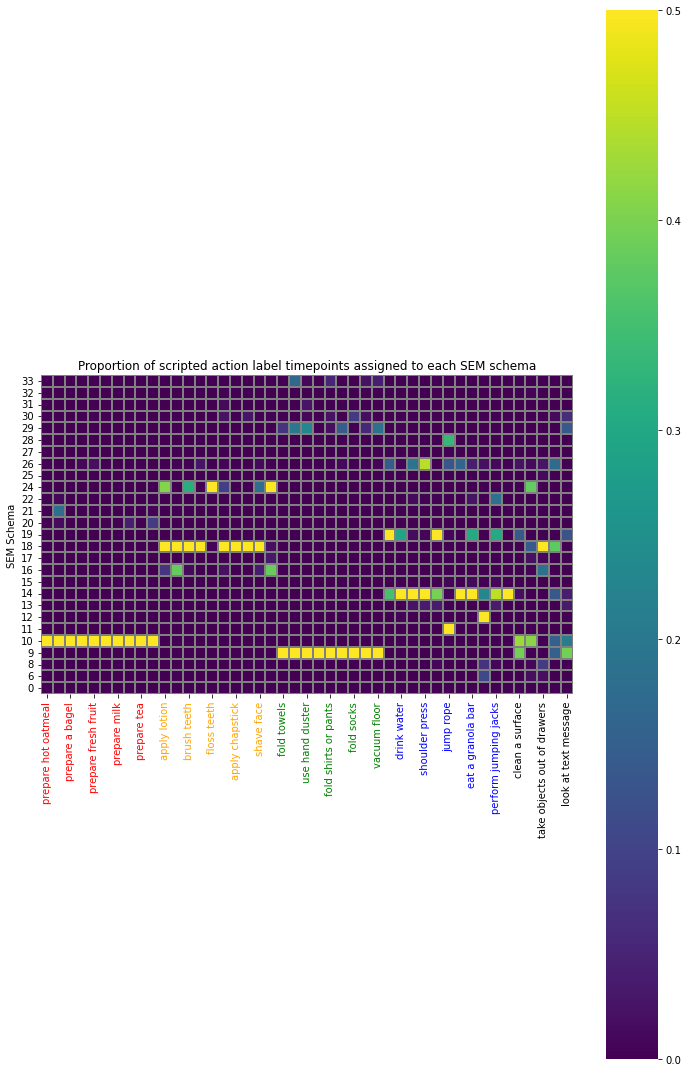

In [20]:
plot_confusion_matrix_figure('101',schemas='active')

In [30]:
def plot_instance_confusion_matrix(epoch,schemas='all'):
    # epoch : string
    # schemas : 'all' includes blank rows for all schemas, 'active' is just schemas active in selected epoch
    f, ax = plt.subplots(figsize=(30,20))
    tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev_instance'] != 'none')]
    evdict={}
    for evfac in tdf.ev_fact_instance.unique():
        evdict[evfac]=tdf[tdf.ev_fact_instance==evfac]['ev_instance'].iloc[0]
    # compute cross-tabs of SEM events and ground-truth annotations:
    ct=pd.crosstab(tdf.e_hat,tdf.ev_instance)
    
    # Omit 'none' timepoints:
    ct = ct[[x for x in ct.columns if 'none' not in x]]
    
    # Omit scripted actions that appear in a single instance in validation set:
    single_actions = ['prepare yogurt with granola','prepare orange juice',
                     'prepare milk','prepare fresh fruit','apply chapstick',
                     'use hair gel', 'sit ups', 'push ups','take a pill']
    for single in single_actions:
       ct = ct[[x for x in ct.columns if single not in x]]
    
    # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
    # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
    if np.shape(ct)[1] > np.shape(ct)[0]:
        fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
        padded=pd.concat([ct]*fac)
        padded=padded.sort_index()
        row_ind,col_ind=linear_sum_assignment(padded*-1)
    else:
        row_ind,col_ind=linear_sum_assignment(ct*-1)
    if schemas=='all':
        for ehat in range(schemadf.e_hat.max()+1):
            if ehat not in ct.index:
                df1 = pd.DataFrame([[np.nan] * len(ct.columns)], columns=ct.columns,index=[ehat])
                ct = ct.append(df1)
    elif schemas=='active':
        pass       
    ct=ct.sort_index()
    # Convert to proportions by column:
    ct = ct/ct.sum()
    '''
    # Add percent purity of schemas to index:
    schema_purity = zip(ct.index,round(ct.max(axis=1)/ct.sum(axis=1),2))
    ct.index=[str(x[0]) + ' - ' + str(x[1]) for x in schema_purity]
    # Add coverage:
    label_coverage = zip(ct.columns,round(ct.max(axis=0)/ct.sum(axis=0),2))
    ct.columns=[str(x[0]) + ' - ' + str(x[1]) for x in label_coverage]
    '''
    if len(ct.columns)==len(col_ind):
        plt.cla()
        # sort columns based on column index:
        # ctplot=ct.iloc[:,col_ind]
        # alphabetize columns:
        #ctplot=ct[sorted(ct.columns)]
        # sort by chapter type:
        cinst=[colors[x.rstrip(' -.0123456789')]+' '+x for x in ct.columns]
        ctplot = ct[ct.columns[np.argsort(cinst)[::-1]]]
        #ctplot=ct[ct.columns[np.argsort(ct.columns.str.split('.').str[-3])]]
        #sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0.000,vmax=150,norm=LogNorm(),square=True)
        ax = sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0,vmax=0.5,square=True,linewidths=0.1,linecolor='gray')
        #sns.heatmap(ctplot, mask=ctplot != 0, cbar=False, color = "white")
        ax.invert_yaxis()
        for tick in ax.get_xticklabels(): 
            tick.set_color(colors[tick._text.rstrip(' -.0123456789')])
        
        # Add activity type labels to x axis:
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',size=35)) 
                    for text,color in zip(['breakfast   ','bathroom                           ',
                                           'cleaning                                 ','exercise         ','multi-activity'],
                                          ['red','orange','green','blue','black']) ]
        xbox = HPacker(children=boxes,align="center",pad=-175, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=0,frameon=False,bbox_to_anchor=(0.1, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)
        
        # Set colorbar font size:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=35)
        
        # Set axis labels
        plt.ylabel('SEM Schema', fontsize=35)
        plt.xlabel('')
        #plt.title(f'Epoch {epoch} - {cache_tag}')
        #plt.title(f'{cache_tag}\nProportion of scripted action label scenes assigned to each SEM schema', fontsize=35)
        plt.title(f'Proportion of scripted action label scenes assigned to each SEM schema', fontsize=35)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_instance_epoch_{epoch}_{cache_tag}.png', dpi=300)
        

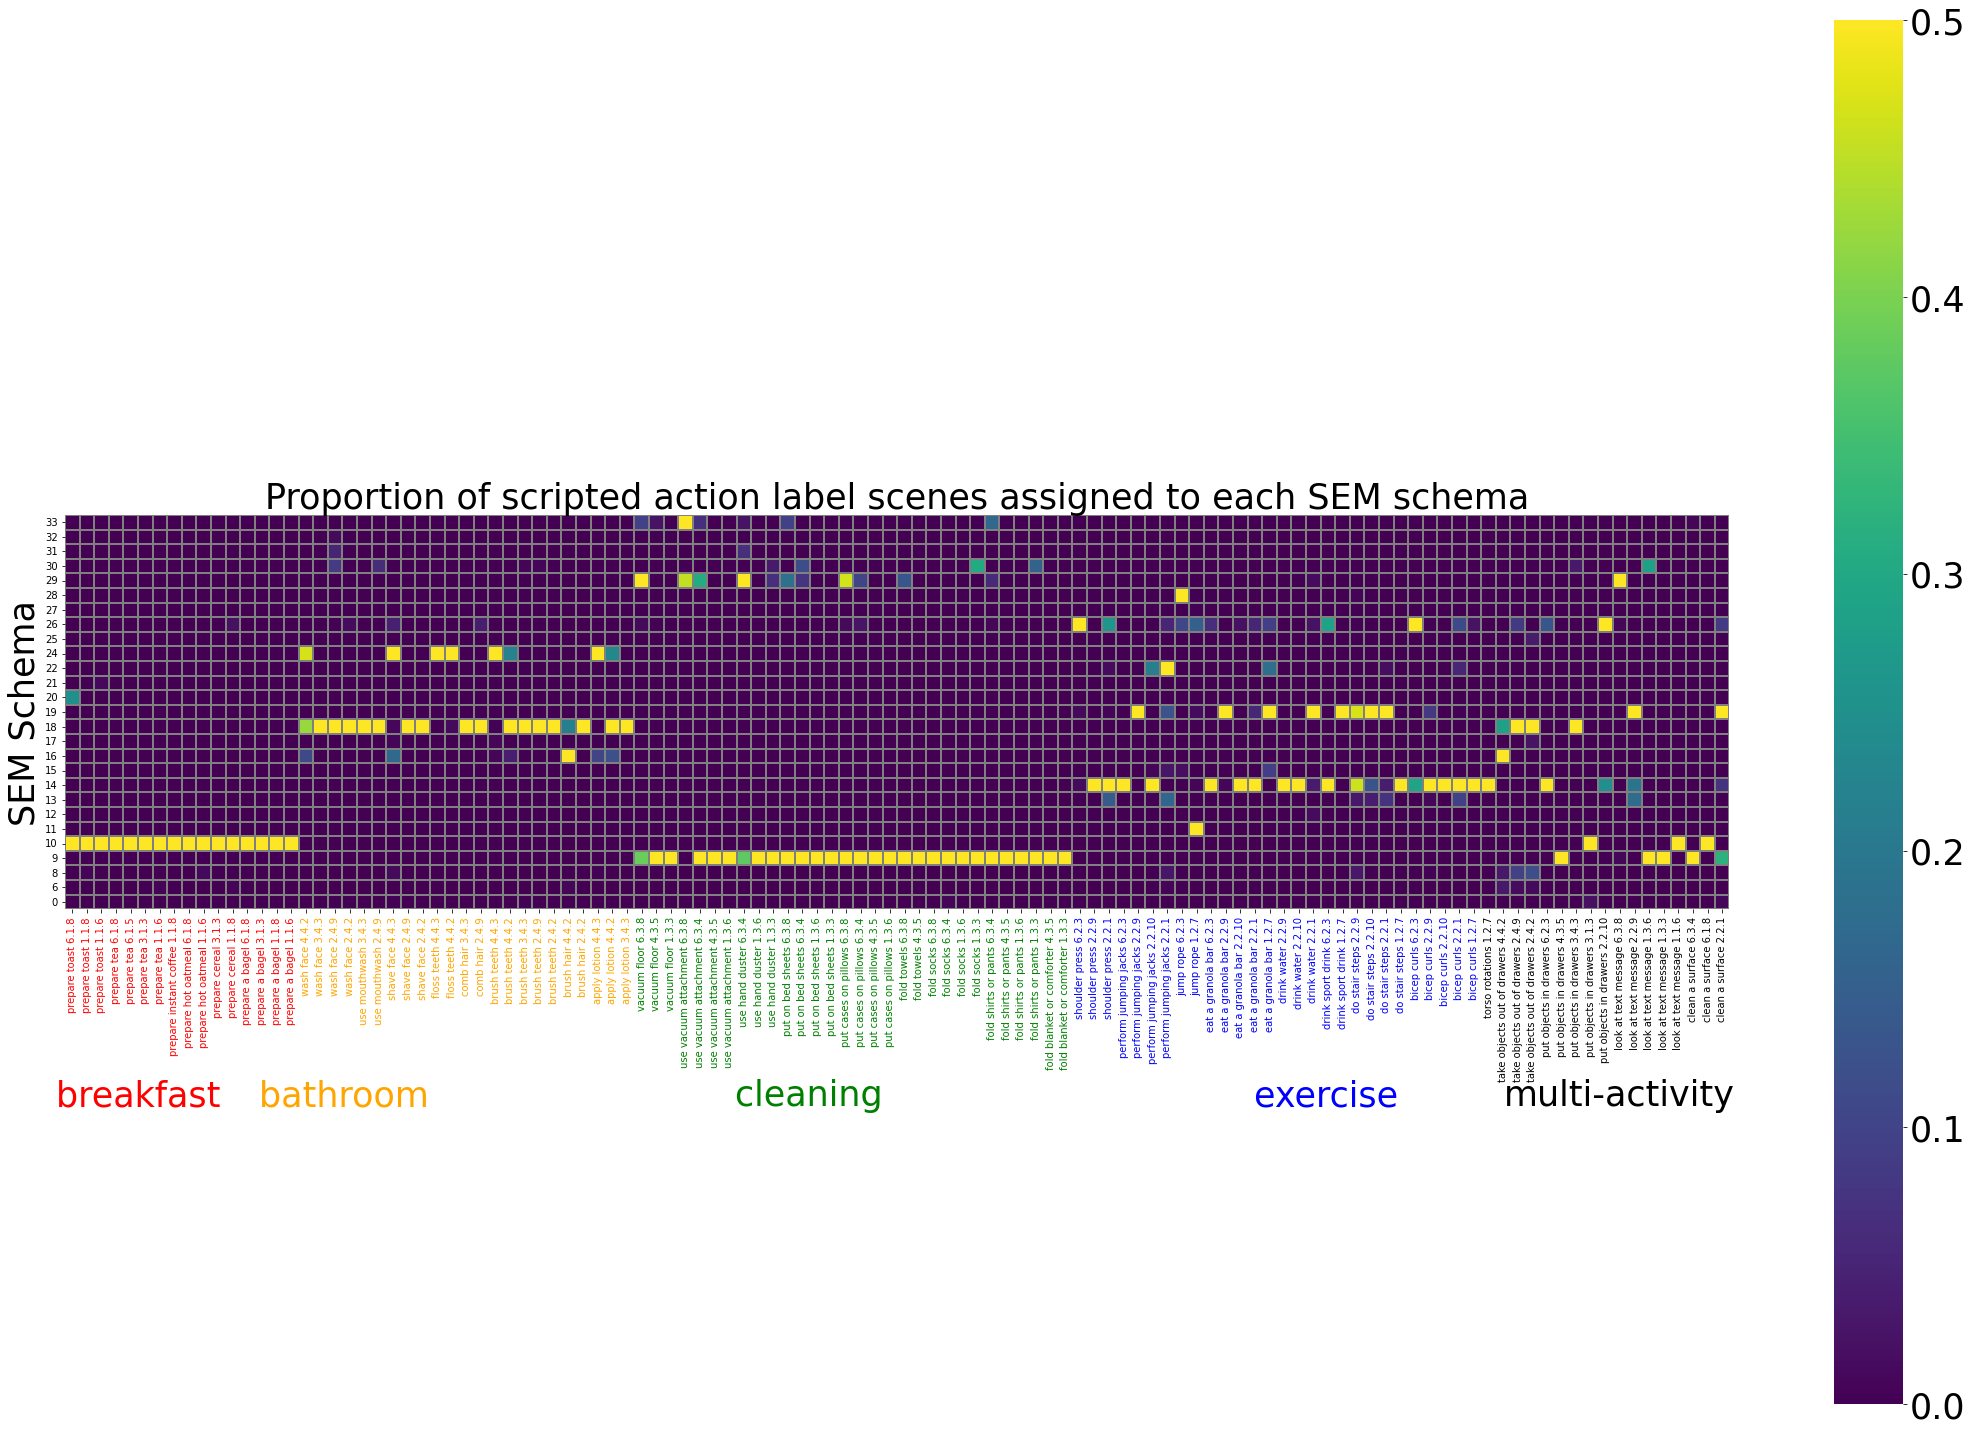

In [31]:
plot_instance_confusion_matrix('101',schemas='active')

In [32]:
def plot_instance_confusion_matrix_random(epoch,schemas='all'):
    # epoch : string
    # schemas : 'all' includes blank rows for all schemas, 'active' is just schemas active in selected epoch
    f, ax = plt.subplots(figsize=(30,20))
    tdf=deepcopy(schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev_instance'] != 'none')])
    tdf['e_hat'] = np.random.permutation(tdf.e_hat.values)
    evdict={}
    for evfac in tdf.ev_fact_instance.unique():
        evdict[evfac]=tdf[tdf.ev_fact_instance==evfac]['ev_instance'].iloc[0]
    # compute cross-tabs of SEM events and ground-truth annotations:
    ct=pd.crosstab(tdf.e_hat,tdf.ev_instance)
    
    # Omit 'none' timepoints:
    ct = ct[[x for x in ct.columns if 'none' not in x]]
    
    # Omit scripted actions that appear in a single instance in validation set:
    single_actions = ['prepare yogurt with granola','prepare orange juice',
                     'prepare milk','prepare fresh fruit','apply chapstick',
                     'use hair gel', 'sit ups', 'push ups','take a pill']
    for single in single_actions:
       ct = ct[[x for x in ct.columns if single not in x]]
    
    # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
    # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
    if np.shape(ct)[1] > np.shape(ct)[0]:
        fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
        padded=pd.concat([ct]*fac)
        padded=padded.sort_index()
        row_ind,col_ind=linear_sum_assignment(padded*-1)
    else:
        row_ind,col_ind=linear_sum_assignment(ct*-1)
    if schemas=='all':
        for ehat in range(schemadf.e_hat.max()+1):
            if ehat not in ct.index:
                df1 = pd.DataFrame([[np.nan] * len(ct.columns)], columns=ct.columns,index=[ehat])
                ct = ct.append(df1)
    elif schemas=='active':
        pass       
    ct=ct.sort_index()
    # Convert to proportions by column:
    ct = ct/ct.sum()
    '''
    # Add percent purity of schemas to index:
    schema_purity = zip(ct.index,round(ct.max(axis=1)/ct.sum(axis=1),2))
    ct.index=[str(x[0]) + ' - ' + str(x[1]) for x in schema_purity]
    # Add coverage:
    label_coverage = zip(ct.columns,round(ct.max(axis=0)/ct.sum(axis=0),2))
    ct.columns=[str(x[0]) + ' - ' + str(x[1]) for x in label_coverage]
    '''
    if len(ct.columns)==len(col_ind):
        plt.cla()
        # sort columns based on column index:
        # ctplot=ct.iloc[:,col_ind]
        # alphabetize columns:
        #ctplot=ct[sorted(ct.columns)]
        # sort by chapter type:
        cinst=[colors[x.rstrip(' -.0123456789')]+' '+x for x in ct.columns]
        ctplot = ct[ct.columns[np.argsort(cinst)[::-1]]]
        #ctplot=ct[ct.columns[np.argsort(ct.columns.str.split('.').str[-3])]]
        #sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0.000,vmax=150,norm=LogNorm(),square=True)
        ax = sns.heatmap(ctplot,annot=False,cbar=True,cmap='viridis',vmin=0,vmax=0.5,square=True,linewidths=0.1,linecolor='gray')
        #sns.heatmap(ctplot, mask=ctplot != 0, cbar=False, color = "white")
        ax.invert_yaxis()
        for tick in ax.get_xticklabels(): 
            tick.set_color(colors[tick._text.rstrip(' -.0123456789')])
        
        # Add activity type labels to x axis:
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',size=35)) 
                    for text,color in zip(['breakfast   ','bathroom                           ',
                                           'cleaning                                 ','exercise         ','multi-activity'],
                                          ['red','orange','green','blue','black']) ]
        xbox = HPacker(children=boxes,align="center",pad=-175, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=0,frameon=False,bbox_to_anchor=(0.1, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)
        
        # Set colorbar font size:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=35)
        
        # Set axis labels
        plt.ylabel('SEM Schema', fontsize=35)
        plt.xlabel('')
        #plt.title(f'Epoch {epoch} - {cache_tag}')
        #plt.title(f'{cache_tag}\nProportion of scripted action label scenes assigned to each SEM schema', fontsize=35)
        plt.title(f'Proportion of scripted action label scenes assigned to each shuffled SEM schema', fontsize=35)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_instance_random_epoch_{epoch}_{cache_tag}.png', dpi=300)
        

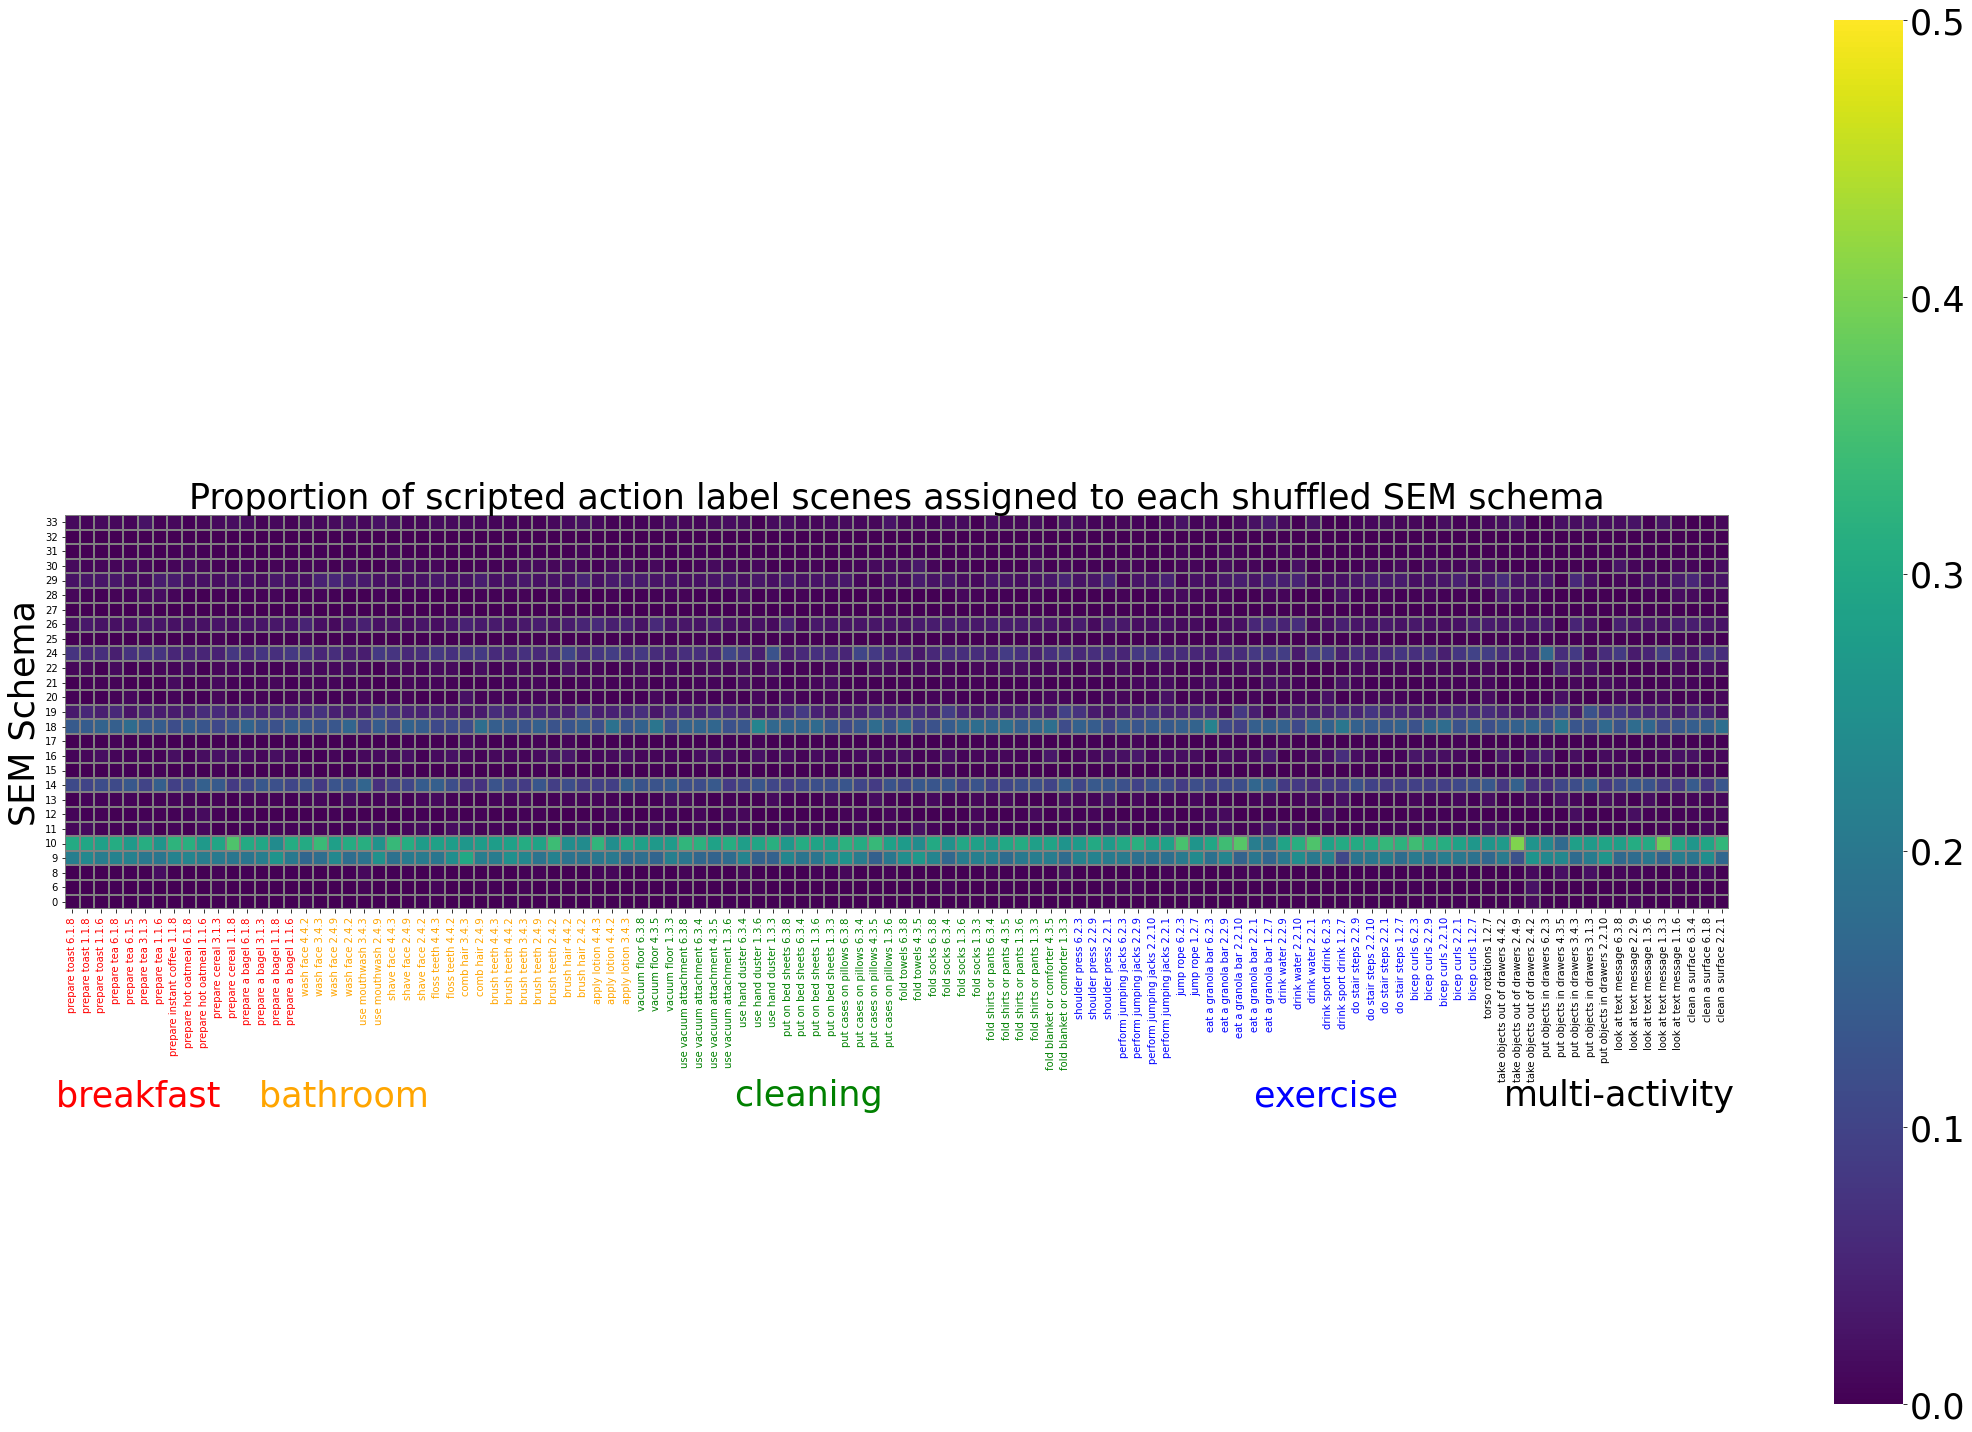

In [33]:
plot_instance_confusion_matrix_random('101',schemas='active')

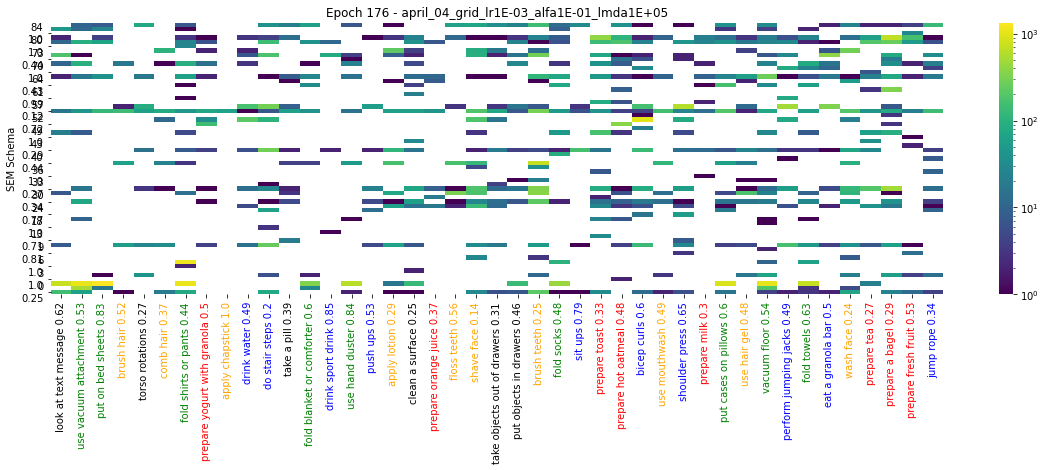

In [232]:
plot_confusion_matrix('176',schemas='active')

In [60]:
def animate_confusion_matrix(schemas='all',col_order='last'):
    
    # epoch : string
    # schemas : 'all' includes blank rows for all schemas, 'active' is just schemas active in selected epoch
    # col_order : string, 'last' fixes columns to final order
    if col_order=='last':
        epoch=epochs[-2]
        #f, ax = plt.subplots(figsize=(20,5))
        tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev'] != 'none')]
        evdict={}
        for evfac in tdf.ev_fact.unique():
            evdict[evfac]=tdf[tdf.ev_fact==evfac]['ev'].iloc[0]
        # compute cross-tabs of SEM events and ground-truth annotations:
        ct=pd.crosstab(tdf.e_hat,tdf.ev)
        
        # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
        # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
        if np.shape(ct)[1] > np.shape(ct)[0]:
            fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
            padded=pd.concat([ct]*fac)
            padded=padded.sort_index()
            row_ind,fixed_col_ind=linear_sum_assignment(padded*-1)
        else:
            row_ind,fixed_col_ind=linear_sum_assignment(ct*-1)
    
    # Set up the figure, the axis, and the plot element we want to animate
    f, ax = plt.subplots(figsize=(20,14))

    # animation function.  This is called sequentially
    def animate(i):      
        epoch=epochs[i]
        f, ax = plt.subplots(figsize=(20,5))
        tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev'] != 'none')]
        evdict={}
        for evfac in tdf.ev_fact.unique():
            evdict[evfac]=tdf[tdf.ev_fact==evfac]['ev'].iloc[0]
        # compute cross-tabs of SEM events and ground-truth annotations:
        ct=pd.crosstab(tdf.e_hat,tdf.ev)
        if col_order=='last':
            col_ind=fixed_col_ind
        else:
            # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
            # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
            if np.shape(ct)[1] > np.shape(ct)[0]:
                fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
                padded=pd.concat([ct]*fac)
                padded=padded.sort_index()
                row_ind,col_ind=linear_sum_assignment(padded*-1)
            else:
                row_ind,col_ind=linear_sum_assignment(ct*-1)
        
        if schemas=='all':
            for ehat in range(schemadf.e_hat.max()+1):
                if ehat not in ct.index:
                    df1 = pd.DataFrame([[np.nan] * len(ct.columns)], columns=ct.columns,index=[ehat])
                    ct = ct.append(df1)
        elif schemas=='active':
            pass       
        ct=ct.sort_index()
        # Add percent purity of schemas to index:
        schema_purity = zip(ct.index,round(ct.max(axis=1)/ct.sum(axis=1),2))
        ct.index=[str(x[0])+' '+str(x[1]) for x in schema_purity]
        label_coverage = zip(ct.columns,round(ct.max(axis=0)/ct.sum(axis=0),2))
        ct.columns=[str(x[0])+' '+str(x[1]) for x in label_coverage]        
        if len(ct.columns)==len(col_ind):
            plt.cla()
            # sort columns based on column index:
            ctplot=ct.iloc[:,col_ind]
            
            sns.heatmap(ctplot,annot=False,cbar=False,cmap='viridis')
            ax.invert_yaxis()
            for tick in ax.get_xticklabels(): 
                tick.set_color(colors[tick._text.rstrip('.0123456789')[:-1]])
            
            plt.ylabel('SEM Schema')
            plt.xlabel('')
            plt.title(f'Epoch {epoch} - {cache_tag}')
            
        return f

    anim = animation.FuncAnimation(f, animate, 
                                   frames=len(epochs)-1, interval=1, blit=False)
    
    anim.save(f'confusion_matrix_animation_{cache_tag}.mp4', fps=2, extra_args=['-vcodec', 'libx264'])
    
    plt.show()

In [64]:
def animate_instance_confusion_matrix(schemas='all',col_order='last'):
    
    # schemas : 'all' includes blank rows for all schemas, 'active' is just schemas active in selected epoch
    # col_order : string, 'last' fixes columns to final order
    sdf=schemadf[schemadf['run'].isin(valid_runs)]
    epochs=sorted(sdf.epoch.unique(),key=int)
    if col_order=='last':
        epoch=epochs[-2]
        #f, ax = plt.subplots(figsize=(20,5))
        tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev_instance'] != 'none')]
        evdict={}
        for evfac in tdf.ev_fact_instance.unique():
            evdict[evfac]=tdf[tdf.ev_fact_instance==evfac]['ev_instance'].iloc[0]
        # compute cross-tabs of SEM events and ground-truth annotations:
        ct=pd.crosstab(tdf.e_hat,tdf.ev_instance)
        
        # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
        # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
        if np.shape(ct)[1] > np.shape(ct)[0]:
            fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
            padded=pd.concat([ct]*fac)
            padded=padded.sort_index()
            row_ind,fixed_col_ind=linear_sum_assignment(padded*-1)
        else:
            row_ind,fixed_col_ind=linear_sum_assignment(ct*-1)
    
    # Set up the figure, the axis, and the plot element we want to animate
    f, ax = plt.subplots(figsize=(20,14))

    # animation function.  This is called sequentially
    def animate(i):      
        epoch=epochs[i]
        f, ax = plt.subplots(figsize=(20,5))
        tdf=schemadf[(schemadf['run'].isin(valid_runs)) & (schemadf['epoch']==epoch) & (schemadf['ev_instance'] != 'none')]
        evdict={}
        for evfac in tdf.ev_fact_instance.unique():
            evdict[evfac]=tdf[tdf.ev_fact_instance==evfac]['ev_instance'].iloc[0]
        # compute cross-tabs of SEM events and ground-truth annotations:
        ct=pd.crosstab(tdf.e_hat,tdf.ev_instance)
        if col_order=='last':
            col_ind=fixed_col_ind
        else:
            # compute linear sum assignment to sort ground-truth labels maximizing match to SEM events:
            # Duplicate SEM rows to match number of ground truth labels if there are fewer SEM events than labels:
            if np.shape(ct)[1] > np.shape(ct)[0]:
                fac=int(np.ceil(np.shape(ct)[1]/np.shape(ct)[0]))   
                padded=pd.concat([ct]*fac)
                padded=padded.sort_index()
                row_ind,col_ind=linear_sum_assignment(padded*-1)
            else:
                row_ind,col_ind=linear_sum_assignment(ct*-1)
        
        if schemas=='all':
            for ehat in range(schemadf.e_hat.max()+1):
                if ehat not in ct.index:
                    df1 = pd.DataFrame([[np.nan] * len(ct.columns)], columns=ct.columns,index=[ehat])
                    ct = ct.append(df1)
        elif schemas=='active':
            pass       
        ct=ct.sort_index()
        # Add percent purity of schemas to index:
        schema_purity = zip(ct.index,round(ct.max(axis=1)/ct.sum(axis=1),2))
        ct.index=[str(x[0])+' '+str(x[1]) for x in schema_purity]
        label_coverage = zip(ct.columns,round(ct.max(axis=0)/ct.sum(axis=0),2))
        ct.columns=[str(x[0])+' '+str(x[1]) for x in label_coverage]        
        if len(ct.columns)==len(col_ind):
            plt.cla()
            # sort columns based on column index:
            ctplot=ct.iloc[:,col_ind]
            
            sns.heatmap(ctplot,annot=False,cbar=False,cmap='viridis')
            ax.invert_yaxis()
            #for tick in ax.get_xticklabels(): 
            #    tick.set_color(colors[tick._text.rstrip('.0123456789')[:-1]])
            
            plt.ylabel('SEM Schema')
            plt.xlabel('')
            plt.title(f'Epoch {epoch} - {cache_tag}')
            
        return f

    anim = animation.FuncAnimation(f, animate, 
                                   frames=len(epochs)-1, interval=1, blit=False)
    
    anim.save(f'confusion_matrix_animation_{cache_tag}.mp4', fps=2, extra_args=['-vcodec', 'libx264'])
    
    plt.show()